In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

%matplotlib inline

In [2]:
def df_add_lword(df):
    """
    'LWord' is a value of 'Word' put into lowercase mode
    """

    df['LWord'] = df['Word'].str.lower()
    return df

def df_add_wordlen(df):
    """
    'WordLen' is a length of 'Word'
    """
    
    df['WordLen'] = df['Word'].apply(lambda x: len(x))
    return df

def df_add_capital(df):
    """
    'Capital' is an indicator of 'Word' beginning with a capital letter
    'Capital' equals one if 'Word' starts with a capital letter and zero otherwise
    """

    df['Capital'] = df['Word'].apply(lambda w: 1 if w[0].isupper() == True else 0)
    return df

def df_add_capital_num(df):
    """
    'CapitalNum' is equal to the number of capital letters in a word
    """

    df['CapitalNum'] = df['Word'].apply(lambda x: sum(1 for c in x if c.isupper()))

    return df

def df_add_capital_all(df):
    """
    'CapitalAll' is equal to 1 if all letters are capital
    """
    
    df['CapitalAll'] = df.apply(lambda row: 1 if row['CapitalNum'] == len(row['Word']) else 0, axis=1)
    
    return df

def df_add_vow_con(df):
    """
    'Vow' is equal to number of vowels in a 'Word'
    'Con' is equal to number of consonants in a 'Word'
    """
    
    df['Vow'] = df['Word'].apply(lambda x: len(re.findall('[уеыаоэяию]', x, re.IGNORECASE)))
    df['Con'] = df['WordLen'] - df['Vow']

    return df

def df_add_non_cyrillic(df):
    """
    'NonCyrillic' is equal to 1 if a 'WordLen' contains at least 1 non-cyrillic symbol
    """

    df['NumCyrillic'] = df['Word'].apply(lambda x: sum(1 for c in x if bool(re.search('[а-яА-ЯёЁ]', c))))
    df['NumNonCyrillic'] = df['WordLen'] - df['NumCyrillic']
    df['NonCyrillic'] = df['NumNonCyrillic'].apply(lambda x: 1 if x > 0 else 0)

    df = df.drop(['NumCyrillic', 'NumNonCyrillic'], axis=1)
    
    return df

def df_add_lastn(df, n):
    """
    'Lastn' is the last n letters of 'LWord'
    """

    df['Last' + str(n)] = df['LWord'].str[-n:]
    return df

def df_add_firstn(df, n):
    """
    'Firstn' is the first n letters of 'LWord'
    """

    df['First' + str(n)] = df['LWord'].str[:n]
    return df

def df_add_lastn_one_hot(df_train, df_test, n):
    """
    One-hot encoding for frequent 'Lastn' values in train data frame
    """

    lastn = 'Last' + str(n)
    features = []

    df_train['One'] = 1
    df_tmp = df_train[['One', lastn]].groupby(lastn).sum().reset_index()
    df_tmp = df_tmp.rename(columns={'One' : 'NumLast'})
    df_tmp = df_tmp[df_tmp['NumLast'] > 100]
    
    df_train = df_train.drop('One', axis=1)
    
    for i in df_tmp[lastn]:
        name = lastn + '_' + i
        df_train[name] = df_train[lastn].apply(lambda x: 1 if x == i else 0)
        df_test[name] = df_test[lastn].apply(lambda x: 1 if x == i else 0)
        features = features + [name]

    return df_train, df_test, features

def df_add_firstn_one_hot(df_train, df_test, n):
    """
    One-hot encoding for frequen 'Firstn' values in train data frame
    """

    firstn = 'First' + str(n)
    features = []

    df_train['One'] = 1
    df_tmp = df_train[['One', firstn]].groupby(firstn).sum().reset_index()
    df_tmp = df_tmp.rename(columns={'One' : 'NumFirst'})
    df_tmp = df_tmp[df_tmp['NumFirst'] > 100]
    
    df_train = df_train.drop('One', axis=1)

    for i in df_tmp[firstn]:
        name = firstn + '_' + i
        df_train[name] = df_train[firstn].apply(lambda x: 1 if x == i else 0)
        df_test[name] = df_test[firstn].apply(lambda x: 1 if x == i else 0)
        features = features + [name]
        
    return df_train, df_test, features

def df_add_lastn_mean(df_train, df_test, n):
    """
    'LastnMean' is equal to the fraction of labeled points in a group of points having same 'Lastn'
    """

    feature = 'Last' + str(n)
    feature_mean = feature + 'Mean'

    if feature_mean in df_train.columns:
        df_train = df_train.drop([feature_mean], axis=1)
        
    if feature_mean in df_test.columns:
        df_test = df_test.drop([feature_mean], axis=1)

    df = df_train[[feature, 'Label']].groupby(feature).mean().reset_index()
    df = df.rename(columns={'Label':feature_mean})

    df_train = pd.merge(df_train, df, how='left')
    
    df_test = pd.merge(df_test, df, how='left')
    mean = np.mean(df_train['Label'])
    df_test[feature_mean] = df_test[feature_mean].fillna(mean)

    return df_train, df_test

def df_add_firstn_mean(df_train, df_test, n):
    """
    'FirstnMean' is equal to the fraction of labeled points in a group of points having same 'Firstn'
    """

    feature = 'First' + str(n)
    feature_mean = feature + 'Mean'
    
    if feature_mean in df_train.columns:
        df_train = df_train.drop([feature_mean], axis=1)
        
    if feature_mean in df_test.columns:
        df_test = df_test.drop([feature_mean], axis=1)
    
    df = df_train[[feature, 'Label']].groupby(feature).mean().reset_index()
    df = df.rename(columns={'Label':feature_mean})

    df_train = pd.merge(df_train, df, how='left')
    
    df_test = pd.merge(df_test, df, how='left')
    mean = np.mean(df_train['Label'])
    df_test[feature_mean] = df_test[feature_mean].fillna(mean)

    return df_train, df_test

In [3]:
def df_prepare_features(df_train, df_test):
    """
    Prepare features that do not depend on 'Label'
    """
    df_test = df_add_lword(df_test)
    df_test = df_add_wordlen(df_test)
    df_test = df_add_capital(df_test)
    df_test = df_add_capital_num(df_test)
    df_test = df_add_capital_all(df_test)
    df_test = df_add_vow_con(df_test)
    df_test = df_add_non_cyrillic(df_test)
    df_test = df_add_lastn(df_test, 1)
    df_test = df_add_lastn(df_test, 2)
    df_test = df_add_firstn(df_test, 1)
    df_test = df_add_firstn(df_test, 2)

    df_train = df_add_lword(df_train)
    df_train = df_add_wordlen(df_train)
    df_train = df_add_capital(df_train)
    df_train = df_add_capital_num(df_train)
    df_train = df_add_capital_all(df_train)
    df_train = df_add_vow_con(df_train)
    df_train = df_add_non_cyrillic(df_train)
    df_train = df_add_lastn(df_train, 1)
    df_train = df_add_lastn(df_train, 2)
    df_train = df_add_firstn(df_train, 1)
    df_train = df_add_firstn(df_train, 2)

    one_hot_features = []
    
    df_train, df_test, features_tmp = df_add_lastn_one_hot(df_train, df_test, 1)
    one_hot_features = one_hot_features + features_tmp
    df_train, df_test, features_tmp = df_add_lastn_one_hot(df_train, df_test ,2)
    one_hot_features = one_hot_features + features_tmp
    
    df_train, df_test, features_tmp = df_add_firstn_one_hot(df_train, df_test, 1)
    one_hot_features = one_hot_features + features_tmp
    df_train, df_test, features_tmp = df_add_firstn_one_hot(df_train, df_test, 2)
    one_hot_features = one_hot_features + features_tmp
    
    return df_train, df_test, one_hot_features

In [4]:
def df_prepare_features_label(df_train, df_test):
    """
    Prepare features that depend on 'Label'
    """

    df_train, df_test = df_add_lastn_mean(df_train, df_test, 1)
    df_train, df_test = df_add_lastn_mean(df_train, df_test, 2)

    df_train, df_test = df_add_firstn_mean(df_train, df_test, 1)
    df_train, df_test = df_add_firstn_mean(df_train, df_test, 2)

    return df_train, df_test

In [5]:
from sklearn.metrics import roc_curve, auc

def show_roc(df):

    fpr, tpr, thresholds = roc_curve(df['Label'], df['Predict'])
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.5f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [6]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

def xgb_split(df, features):

    X_all = df
    y_all = df['Label']

    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3)
 
    X_train, X_test = df_prepare_features_label(X_train, X_test)
    
    d_train = xgb.DMatrix(X_train[features], label=X_train['Label'])
    d_test = xgb.DMatrix(X_test[features], label=X_test['Label'])
    
    params = {'max_depth': 15, 
              'min_child_weight': 150, 
              #'subsample': 0.9,
              #'colsample_bytree': 0.7,  
              #'colsample_bylevel': 0.7,
              'lambda': 0.1,
              'alpha': 0.1,
              'eta': 0.5, 
              'objective': 'binary:logistic',
              'eval_metric' : 'auc',
              'silent': 1,
              'seed': 17
             }
    
    watchlist = [(d_train, 'train'), (d_test, 'test')]
    clf = xgb.train(params, d_train, 30000, watchlist, early_stopping_rounds=100, verbose_eval=10)
    
    df_tmp = pd.DataFrame()
    df_tmp['Label'] = X_test['Label']
    df_tmp['Predict'] = clf.predict(xgb.DMatrix(X_test[features]))
   
    show_roc(df_tmp)
    
    return clf

In [7]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train, df_test, one_hot_features = df_prepare_features(df_train, df_test)
df_train, df_test = df_prepare_features_label(df_train, df_test)

[0]	train-auc:0.898806	test-auc:0.888645
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[10]	train-auc:0.910132	test-auc:0.898804
[20]	train-auc:0.913396	test-auc:0.900382
[30]	train-auc:0.916437	test-auc:0.901469
[40]	train-auc:0.918533	test-auc:0.902448
[50]	train-auc:0.920419	test-auc:0.903488
[60]	train-auc:0.921803	test-auc:0.903958
[70]	train-auc:0.923108	test-auc:0.904263
[80]	train-auc:0.924284	test-auc:0.904122
[90]	train-auc:0.925283	test-auc:0.904275
[100]	train-auc:0.926326	test-auc:0.904439
[110]	train-auc:0.927297	test-auc:0.904317
[120]	train-auc:0.928221	test-auc:0.90412
[130]	train-auc:0.929115	test-auc:0.904178
[140]	train-auc:0.929912	test-auc:0.90411
[150]	train-auc:0.930697	test-auc:0.904187
[160]	train-auc:0.931362	test-auc:0.904265
[170]	train-auc:0.931941	test-auc:0.904195
[180]	train-auc:0.932602	test-auc:0.90413
[190]	train-auc:0.933213	test-auc:0.904279
[200]	train-

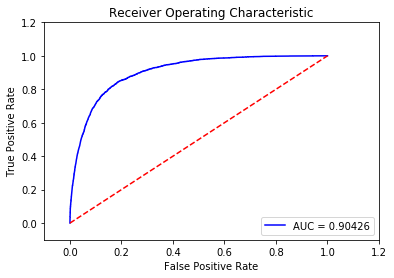

In [8]:
features= one_hot_features + ['Capital', 'CapitalNum', 'CapitalAll', 'WordLen', 'Vow', 'Con', 'NonCyrillic'] + ['Last1Mean', 'Last2Mean', 'First1Mean', 'First2Mean']

clf = xgb_split(df_train, features)

df_test['Predict'] = clf.predict(xgb.DMatrix(df_test[features]))

sub = pd.DataFrame({'Id':range(0, len(df_test)), 'Prediction':df_test['Predict']})
sub.to_csv('submission.csv', index=False)